In [2]:
# case specification
dafiCase = '../case-5/'
sampleId = 15
timeDir = 102

In [3]:
#############################################################################
# load data
#############################################################################
# plot flow field
import os
import numpy as np
import fluidfoam as ff

##############################################################################
foamCase = os.path.join(dafiCase, 'results_ensemble', f'sample_{sampleId}')
U = ff.readvector(foamCase, f'{timeDir:g}', 'U')
q1 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta1_Scaled')
q2 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta2_Scaled')
q3 = ff.readscalar(foamCase, f'{timeDir:g}', 'ratio_Viscosity_Scaled')
q4 = ff.readscalar(foamCase, f'{timeDir:g}', 'ratio_Product_Scaled')
q5 = ff.readscalar(foamCase, f'{timeDir:g}', 'ratio_RAll2RNormal_Scaled')
g1 = ff.readscalar(foamCase, f'{timeDir:g}', 'g1')
g2 = ff.readscalar(foamCase, f'{timeDir:g}', 'g2')
x, y, z = ff.readmesh(foamCase)

features = np.concatenate(
    (q1.reshape(-1, 1), q2.reshape(-1, 1), q3.reshape(-1, 1), q4.reshape(
        -1, 1), q5.reshape(-1, 1)),
    axis=1)

print(features[:, 0].min(), features[:, 0].max())

# features_scaled = np.copy(features)
# for j in range(np.shape(features)[1]):
#     features_scaled[:, j] = features[:, j] / (np.abs(features[:, j]) + 1.0)

print(features[:, 0].min(), features[:, 0].max())

g = np.concatenate((g1.reshape(-1, 1), g2.reshape(-1, 1)), axis=1)


Reading file ../case-5/results_ensemble\sample_15\102\U
Reading file ../case-5/results_ensemble\sample_15\102\theta1_Scaled
Reading file ../case-5/results_ensemble\sample_15\102\theta2_Scaled
Reading file ../case-5/results_ensemble\sample_15\102\ratio_Viscosity_Scaled
Reading file ../case-5/results_ensemble\sample_15\102\ratio_Product_Scaled
Reading file ../case-5/results_ensemble\sample_15\102\ratio_RAll2RNormal_Scaled
Reading file ../case-5/results_ensemble\sample_15\102\g1
Reading file ../case-5/results_ensemble\sample_15\102\g2
Reading file ../case-5/results_ensemble\sample_15/constant/polyMesh/owner
Reading file ../case-5/results_ensemble\sample_15/constant/polyMesh/faces
Reading file ../case-5/results_ensemble\sample_15/constant/polyMesh/points
Reading file ../case-5/results_ensemble\sample_15/constant/polyMesh/neighbour
1.93758e-09 0.949394
1.93758e-09 0.949394


0.00020425754602373605 -5.36156e-06 -1.0951390884590224e-09


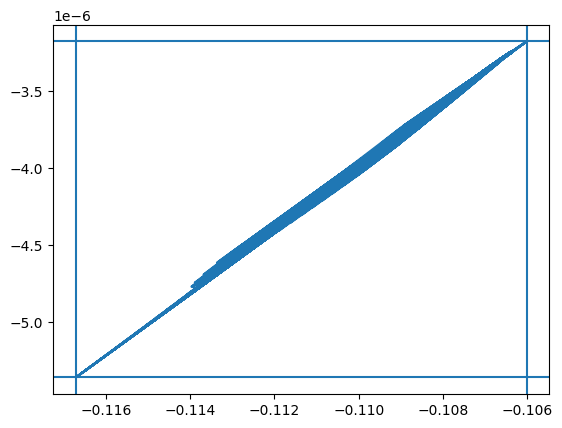

In [4]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
k = (g2.max() - g2.min()) / (g1.max() - g1.min())

print(k, g2.min(), k * g2.min())

g_ = np.linspace(g1.min(), g1.max(), 1001)

ax.plot(g1, g2)
ax.axhline(g2.min())
ax.axhline(g2.max())
ax.axvline(g1.min())
ax.axvline(g1.max())
# ax.plot(g_, k * (g_ - g1.min()) + g2.min())

In [5]:
import numpy as np
import tensorflow as tf
import time
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

f = open('log.python_module', 'w+')
print('_________________________________________________________________',
      file=f)
print('Computing function of scalar invariants from Python module', file=f)
print('Tensorflow version', tf.__version__, file=f)
print('_________________________________________________________________',
      file=f)

tf.keras.backend.clear_session()
# load model
model_path = '../NN-PRE-TRAIN/nn-model-192.h5'
model = tf.keras.models.load_model(model_path)
# model.summary()

# load weights
# get weights flatten
weights_flatten = np.loadtxt(foamCase + '/nn_weights_flatten.dat')
# weights_flatten = np.loadtxt('/home/wuct/dafi/pehills-NN-closure/inputs/w.0')

# get model shape
shapes = []
for iw in model.trainable_variables:
    shapes.append(iw.shape)

# shapes to sizes
sizes = []
for shape in shapes:
    isize = 1
    for ishape in shape:
        isize *= ishape
    sizes.append(isize)

# reshape weights
w_reshaped = []
i = 0
for shape, size in zip(shapes, sizes):
    w_reshaped.append(weights_flatten[i:i + size].reshape(shape))
    i += size
    # print(w_reshaped)
model.set_weights(w_reshaped)

print(model.get_weights(), file=f)
print('Neural-network weights loaded successfully', file=f)

# load scale tick
# scale_tick = np.loadtxt('/home/wuct/dafi/pehills-NN-closure/NN-PRE-TRAIN/scale_tick.dat')
# print('Load scale tick successfully\n')


def ml_func(array):
    # print(np.shape(array))
    t1 = time.time()

    # for i in range(np.shape(array)[1]):
    #     pass
    #     array[:, i] = array[:, i] / (np.abs(array[:, i]) + 1.0)
        # print('feature', i, 'min', f'{array[:, i].min():.6e}', 'max',
        #       f'{array[:, i].max():.6e}')

    g_ = model(array, training=False)

    g = np.array(g_).reshape(-1, 2).astype('double')
    scale = [5.e-1, 1.e-4]  # [0.1,0.001,0.001,0.001]
    init = [-0.09, 0]  # [-0.09,1e-4,1e-4,1e-4]
    for i in range(g.shape[1]):
        g[:, i] = scale[i] * g[:, i] + (1.0 - scale[i]) * init[i]
        # g[:, i] = scale[i] * g[:, i] + init[i]

    # print('g1 min max', g[:, 0].min(), g[:, 0].max())
    # print('g2 min max', g[:, 1].min(), g[:, 1].max())

    for i in range(g.shape[0]):
        for j in range(g.shape[1]):
            if j == 0 and g[i, j] > -0.0: g[i, j] = -0.0

    # print('using tensorflow time', time.time() - t1)

    return g


c:\Python311\Lib\site-packages\tensorflow\python\debug\cli\debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


In [6]:
##########################################################################################
# PFI explnanation for NN model and SHIH function
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import numpy as np

depth = 100
rfr_g1_NN = RandomForestRegressor(max_depth=depth)
# rfr_g1_SHIH = RandomForestRegressor(max_depth=depth)
rfr_g1_NN.fit(features, g[:, 0])

error = np.abs(g[:, 0] - ml_func(features)[:, 0])
print('error   NN, min, max, mean', error.min(), error.max(), error.mean())
error_NN = np.abs(rfr_g1_NN.predict(features) - g[:, 0])
print('error   NN, min, max, mean', error_NN.min(), error_NN.max(),
      error_NN.mean())

results_pfi_NN = permutation_importance(rfr_g1_NN,
                                        features,
                                        g[:, 0],
                                        n_repeats=200,
                                        random_state=0)
print(results_pfi_NN['importances_mean'])

error   NN, min, max, mean 6.4373090191693905e-12 5.206027030996152e-07 2.4693067071745157e-07
error   NN, min, max, mean 0.0 0.0008528100000001204 1.1635876211786364e-05
[3.17934196 2.71593452 0.70694364 0.02708459 0.02457613]


In [7]:
##########################################################################################
# PFI explnanation for NN model and SHIH function
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import numpy as np

depth = 100
rfr_g2_NN = RandomForestRegressor(max_depth=depth)
rfr_g2_SHIH = RandomForestRegressor(max_depth=depth)
rfr_g2_NN.fit(features, g[:, 1])

error = np.abs(g[:, 1] - ml_func(features)[:, 1])
print('error   NN, min, max, mean', error.min(), error.max(), error.mean())
error_NN = np.abs(rfr_g2_NN.predict(features) - g[:, 1])
print('error   NN, min, max, mean', error_NN.min(), error_NN.max(),
      error_NN.mean())

results_pfi_NN = permutation_importance(rfr_g2_NN,
                                        features,
                                        g[:, 1],
                                        n_repeats=200,
                                        random_state=0)
print(results_pfi_NN['importances_mean'])

error   NN, min, max, mean 5.578995212584658e-16 8.982677460098968e-12 2.578419213800742e-12
error   NN, min, max, mean 2.0626012011844253e-13 1.294640548412719e-07 6.3682744360841215e-09
[3.116138   3.64191275 0.77803263 0.02558073 0.01426625]


In [7]:
###########################################################################################
# plot

import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "Helvetica"
    'figure.dpi': 1000,
    'axes.labelsize': 6,
    'xtick.direction': 'in',
    'xtick.labelsize': 6,
    'xtick.top': True,
    'xtick.major.width': 0.5,
    'ytick.direction': 'in',
    'ytick.labelsize': 6,
    'ytick.right': True,
    'ytick.major.width': 0.5,
    'legend.fontsize': 6,
    'axes.linewidth': 0.5,
    'axes.titlesize': 6,
    'grid.linewidth': 0.5
})

vars = [r'$q_1$', r'$q_2$', r'$q_3$', r'$q_4$', r'$q_5$']

###################################################################
# plot predictions
plotStyleNN = {
    'linestyle': 'none',
    'marker': '.',
    'color': 'gray',
    'markersize': 5,
    'markeredgewidth': 0.5,
    'markerfacecolor': 'none',
    'alpha': 0.3
}

plotStyleReduced = {
    'linestyle': 'none',
    'marker': '.',
    'color': 'dodgerblue',
    'markersize': 2,
    'markeredgewidth': 0.5,
    'alpha': 0.5
}

[3.20711988 2.70846901 0.71125843 0.02543685 0.02089383]


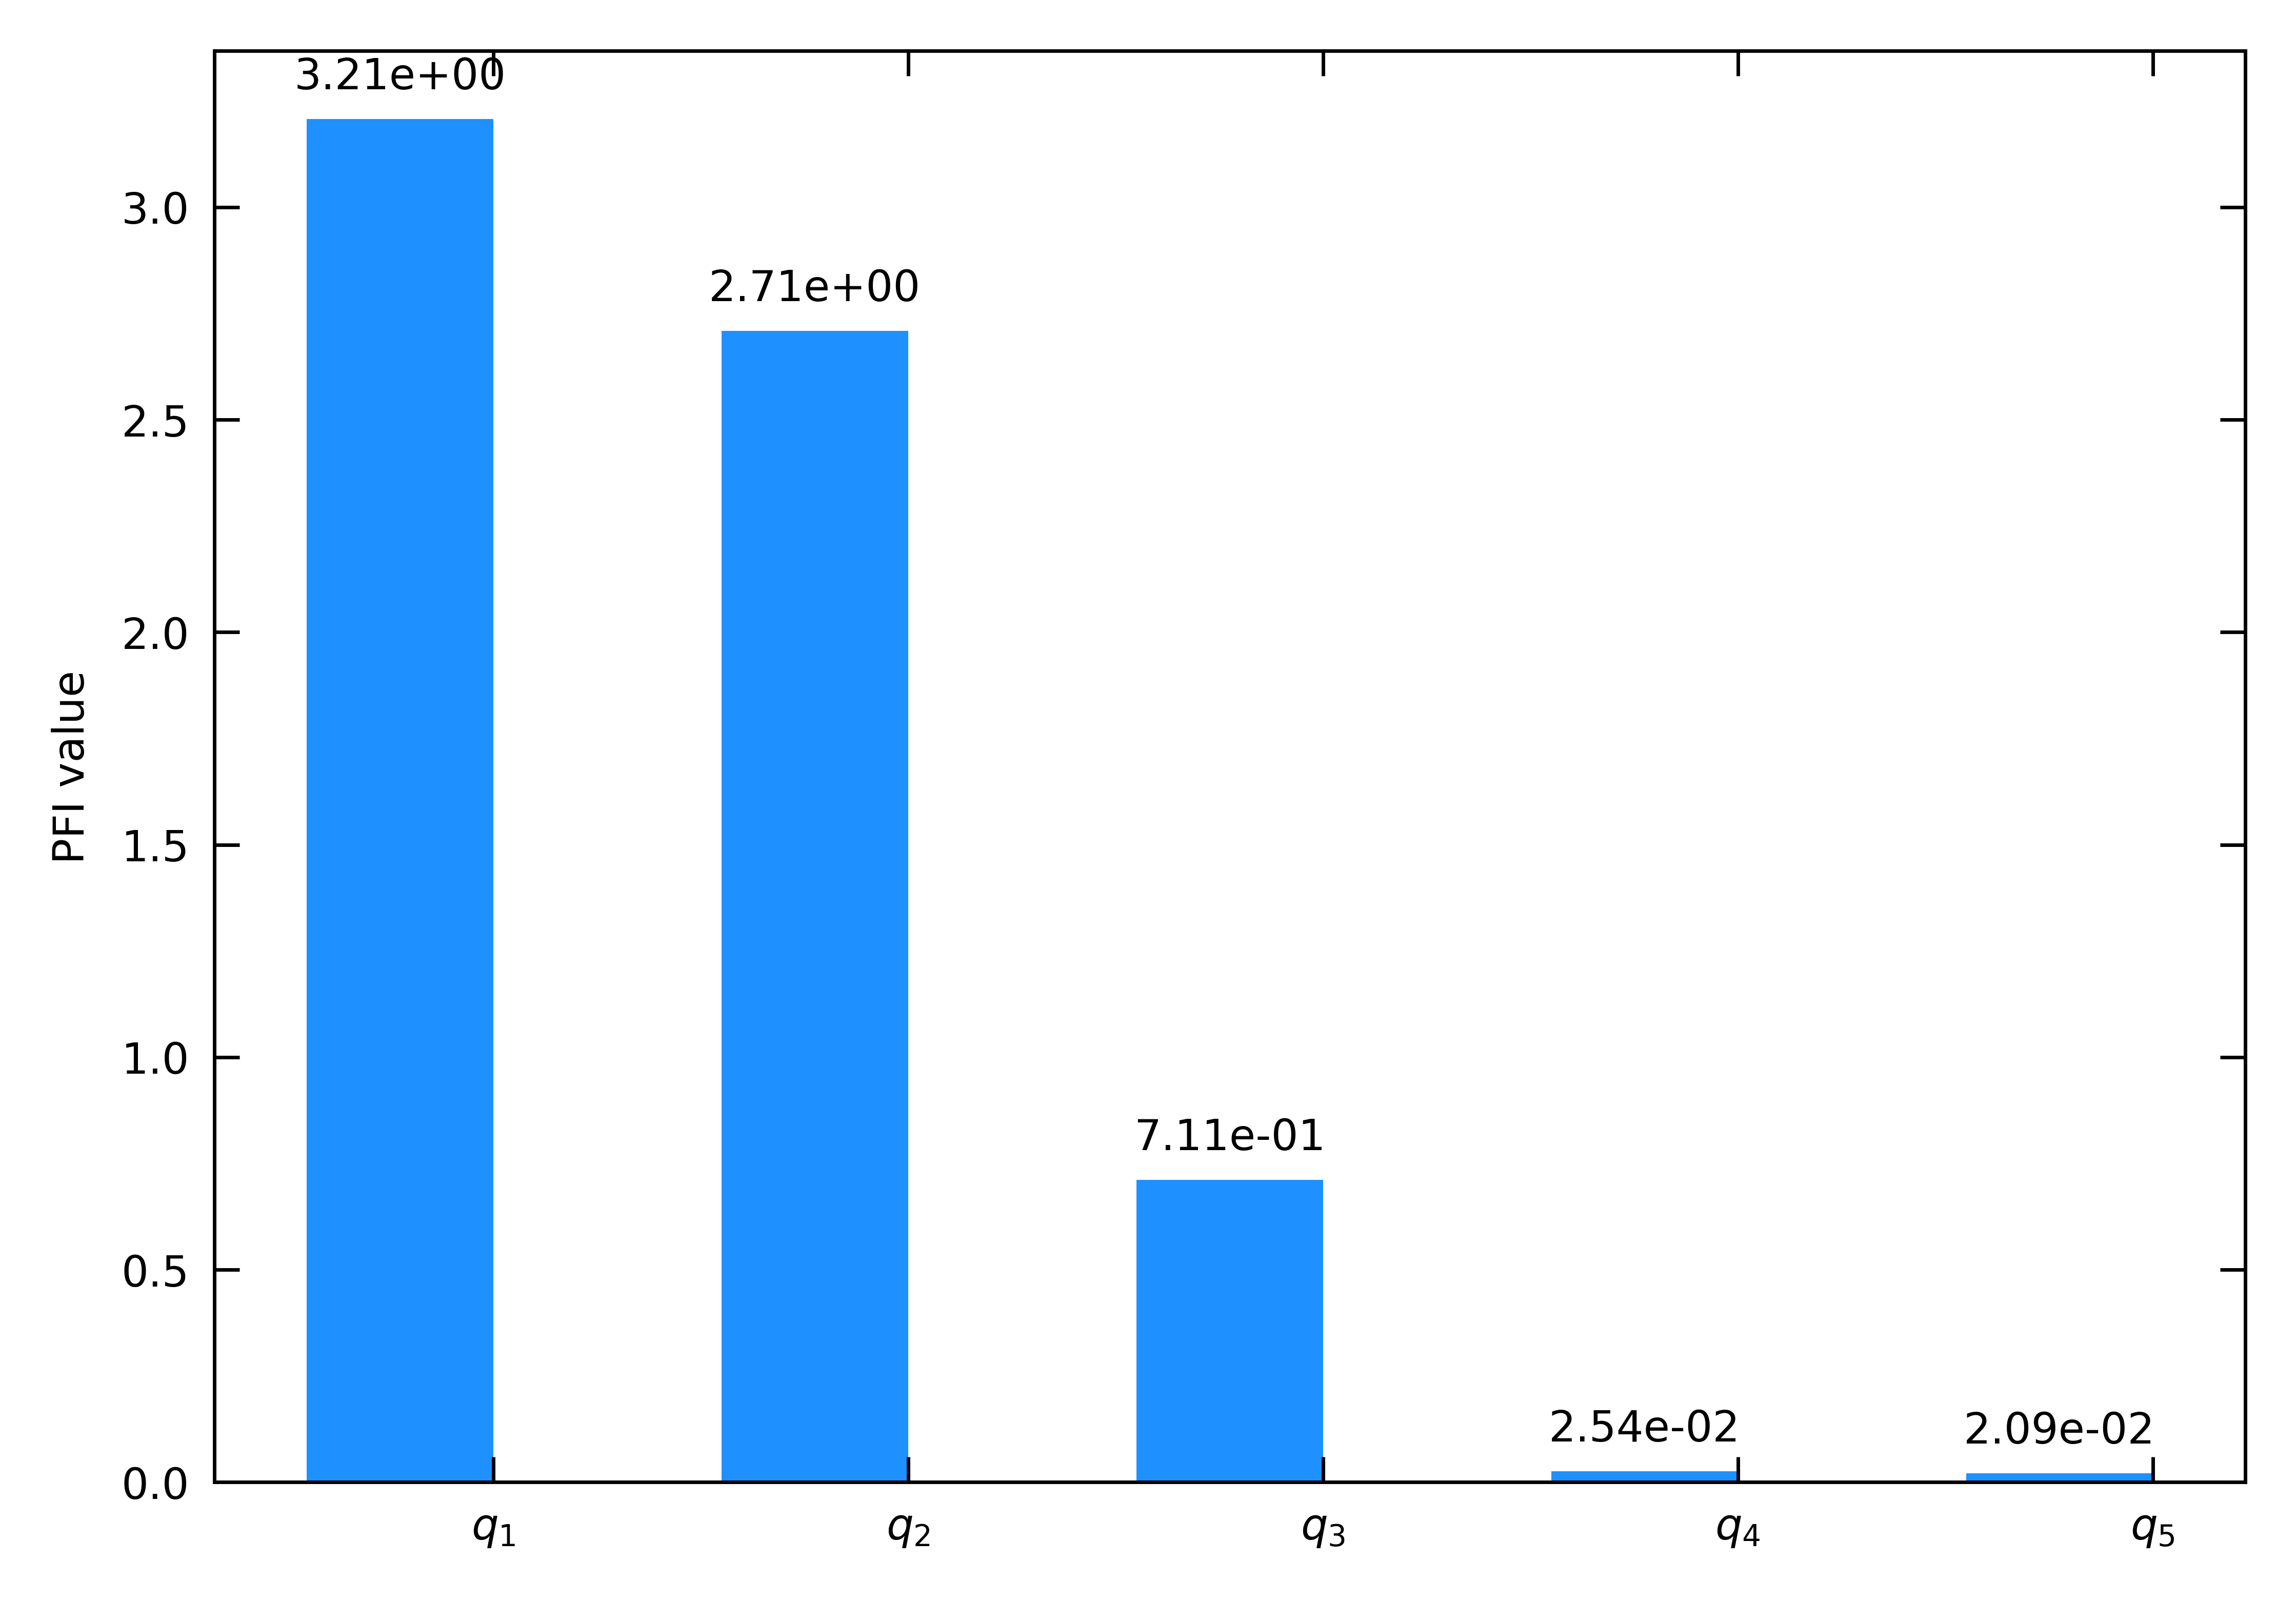

In [9]:
fig, ax = plt.subplots(figsize=(4.5, 3))
width = 0.45
pos = np.arange(len(vars))
bar_pfi = ax.bar(pos,
                 np.abs(results_pfi_NN['importances_mean']),
                 width=width,
                 color='dodgerblue')
ax.set(ylabel='PFI value')
ax.set_xticks(pos + 0.5 * width, vars)
print(results_pfi_NN['importances_mean'])
# ax.set_yscale('log')
# ax.legend()
plt.bar_label(bar_pfi, fmt='%.2e', fontsize=6, padding=3, rotation=0.0)
# plt.bar_label(bar_shih, fmt='%.2e', fontsize=5, padding=3, rotation=40.0)
plt.subplots_adjust(left=0.1, right=0.98, bottom=0.05, top=0.98)
plt.savefig(dafiCase + '/explanation-PFI.png')

In [10]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    'text.latex.preamble': r'\usepackage{amsmath}',
    'figure.dpi': 1000,
    'axes.labelsize': 6,
    'xtick.direction': 'in',
    'xtick.labelsize': 6,
    'xtick.top': True,
    'xtick.major.width': 0.5,
    'ytick.direction': 'in',
    'ytick.labelsize': 6,
    'ytick.right': True,
    'ytick.major.width': 0.5,
    'legend.fontsize': 6,
    'axes.linewidth': 0.5,
    'axes.titlesize': 6,
    'grid.linewidth': 0.5
})

0
1
[['3.207e+00', '2.708e+00', '7.113e-01', '2.544e-02', '2.089e-02'], ['3.116e+00', '3.642e+00', '7.780e-01', '2.558e-02', '1.427e-02']]


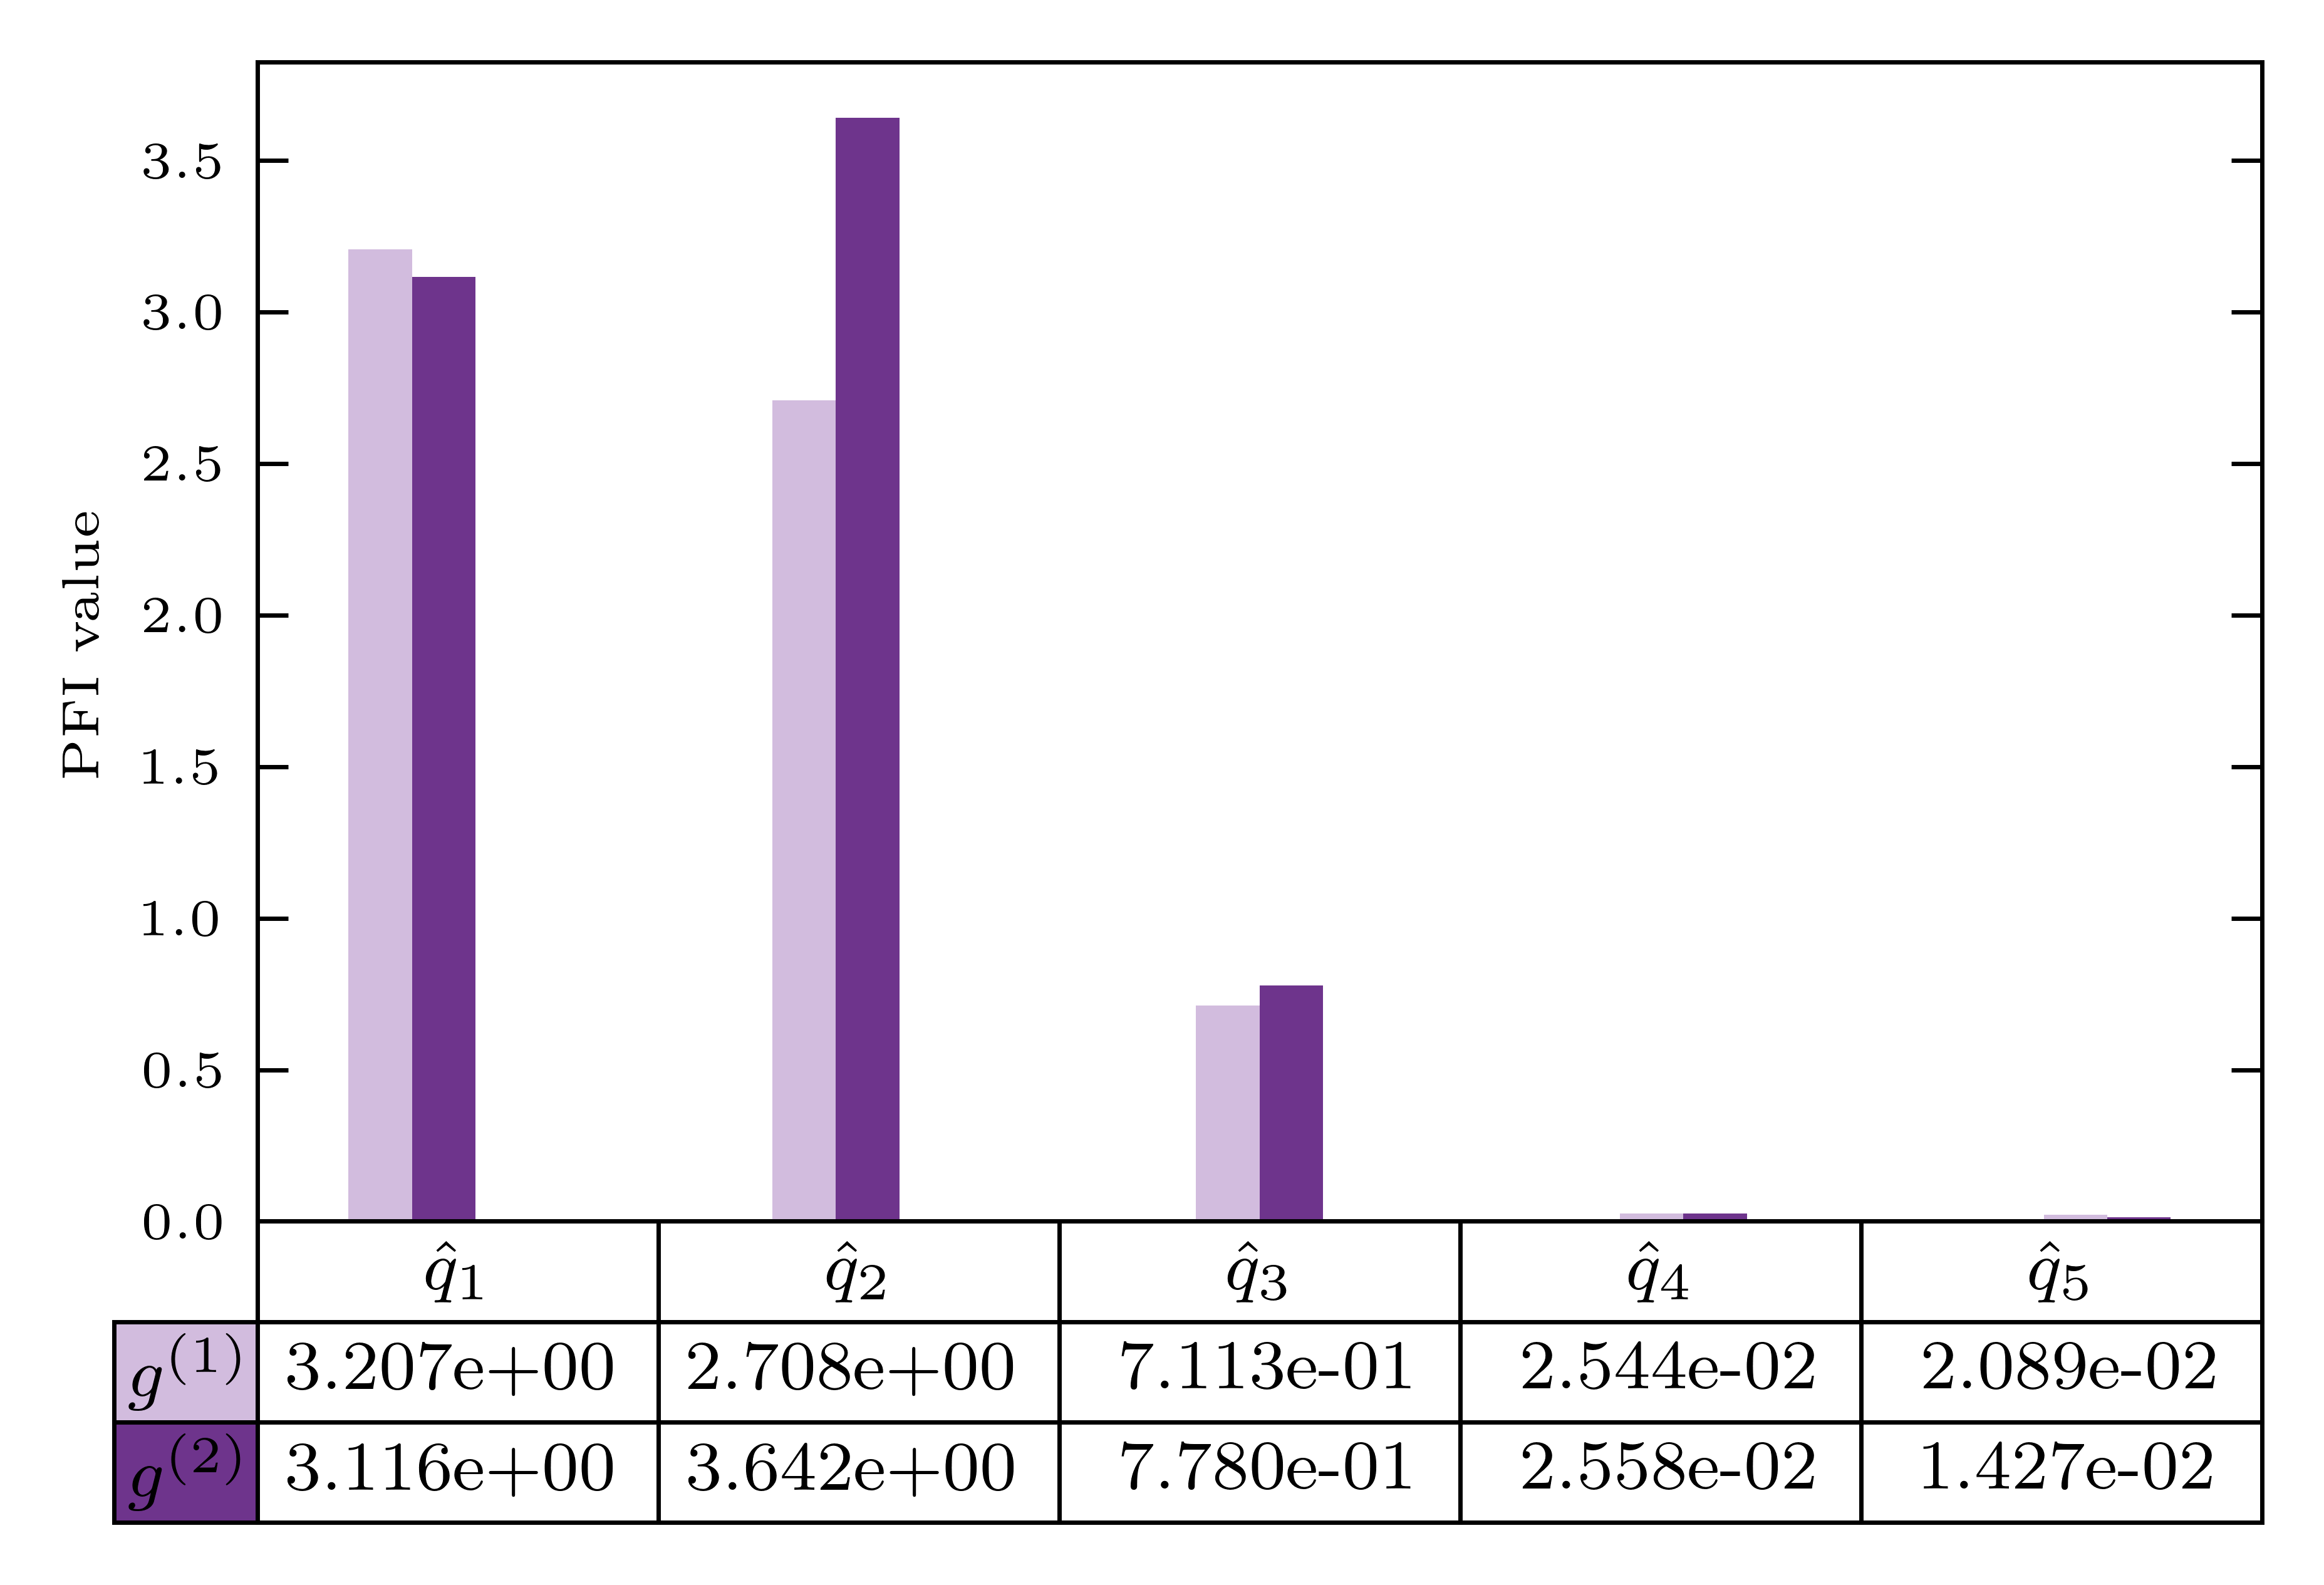

In [12]:
import numpy as np
import matplotlib.pyplot as plt

pfi = [[3.20711988, 2.70846901, 0.71125843, 0.02543685, 0.02089383],
       [3.116138, 3.64191275, 0.77803263, 0.02558073, 0.01426625]]
columns = (r'$\hat{q}_1$', r'$\hat{q}_2$', r'$\hat{q}_3$', r'$\hat{q}_4$',
           r'$\hat{q}_5$')
rows = [r'$g^{(1)}$', r'$g^{(2)}$']

cell_text = []
for row in range(np.shape(pfi)[0]):
    print(row)
    cell_text.append(
        ['%5.3e' % (pfi[row][i]) for i in range(np.shape(pfi)[1])])
print(cell_text)
# colors = ['#D2BCDE', [110, 52, 140], [171, 82, 28], [237, 124, 114]]
colors = ['#D2BCDE', '#6E348C', '#AB521C', '#ED7C72']

fig, ax = plt.subplots(figsize=(4, 2.5))
width = 0.15
for row in range(np.shape(pfi)[0]):
    ax.bar(np.arange(np.shape(pfi)[1]) + width * (row - 2),
           pfi[row],
           width,
           color=colors[row])
table = ax.table(cellText=cell_text,
                 rowLabels=rows,
                 colLabels=columns,
                 rowColours=colors,
                 loc='bottom')
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)  # Set the desired line width
ax.set_xticks([])
ax.set(ylabel=r'$\text{PFI value}$')
plt.subplots_adjust(bottom=0.25, top=0.99, left=0.1, right=0.9)
plt.savefig('pfi-pehills.png')


In [ ]:
import aifeynman
import os
import numpy as np
##########################################################################
# create data used for symbolic regression
print(np.shape(features), np.shape(g[:, 0]))
for j in range(np.shape(features)[1]):
    features[:, j] = features[:, j] / (np.abs(features[:, j]) + 1.0)

data = np.concatenate((features[:, [0, 1, 2]], g[:, 0].reshape(-1, 1)), axis=1)
print(np.shape(data))
np.savetxt('aifeynman/sample/sample-data.dat', data)

# do symbolic regression
os.chdir(os.path.join(os.getcwd(), 'aifeynman'))
aifeynman.run_aifeynman('./sample/',
                        'sample-data.dat',
                        480,
                        'my-ops.txt',
                        polyfit_deg=4,
                        NN_epochs=1000,
                        test_percentage=15)
os.chdir('../')

In [49]:
def g1_sr_1(x0, x1, x2):
    import numpy as np
    f = -0.035526000000 * ((np.exp(np.exp((((x0 / x1) - 1) - 1))) + 1) + 1)
    f = -0.052369288909 * np.sqrt((np.pi + np.exp(np.exp(((x0 / x1) - 1)))))
    return f


def g1_sr_2(x0, x1, x2):
    import numpy as np
    f = (-1.106829745041 + np.cos((np.cos(
        (x2 / np.pi)) - 1))) * (0.145206807559 + np.cos(((x0 + x1) + np.cos(
            ((x0 + x1) + 1)))))
    return (f - f.max()) + f.max()


def g1_sr_3(x0, x1, x2):
    import numpy as np
    f = (-11.128378112501 + (x2 * ((np.log(
        (np.pi - 1)))**(-1) - x2))) * (0.761228865150 +
                                       ((x1 + (x0 + (np.pi + 1))))**(-1))
    return f / 100.0


def g1_sr_4(x0, x1, x2):
    import numpy as np
    f = -10.949984880392 + (x0 + (x1 / (np.pi - (x2 + 1))))
    return f / 100.0


def g1_sr_scaled_1(x0, x1, x2):
    import numpy as np
    # f = -0.245166864049 + (np.pi / (np.exp(np.pi) -
    #                                 (x0 + ((x1 + ((x1 + (np.exp(
    #                                     (x2 + x2)) - 1)))**(-1))))))
    # f = -0.148623556511 + (
    #     (np.exp(np.pi) -
    #      np.log(np.abs((x0 + ((x1 + ((x1 + (np.exp(
    #          (x2 + x2)) - 1)))**(-1))))))))**(-1)
    f = 0.110605415531 * (((x0 + ((x1 + ((x1 + (np.exp(
        (x2 + x2)) - 1)))**(-1)))) / np.exp(
            (np.exp(abs((x0 + ((x1 + ((x1 + (np.exp(
                (x2 + x2)) - 1)))**(-1)))))) + 1))) - 1)
    return f


/tmp/ipykernel_20333/218738406.py:41: RuntimeWarning: overflow encountered in exp
  (np.exp(abs((x0 + ((x1 + ((x1 + (np.exp(
/tmp/ipykernel_20333/218738406.py:40: RuntimeWarning: overflow encountered in exp
  (x2 + x2)) - 1)))**(-1)))) / np.exp(


f1 error 0.0005160622540444055
f2 error 0.00063895914389467
f3 error 0.0007122532694814641
f4 error 0.0005339274581613024
f1 error 0.0005160622540444055
f2 error 0.00063895914389467
f3 error 0.0007122532694814641
f4 error 0.0005339274581613024
f1 error 0.0005160622540444055
f2 error 0.00063895914389467
f3 error 0.0007122532694814641
f4 error 0.0005339274581613024


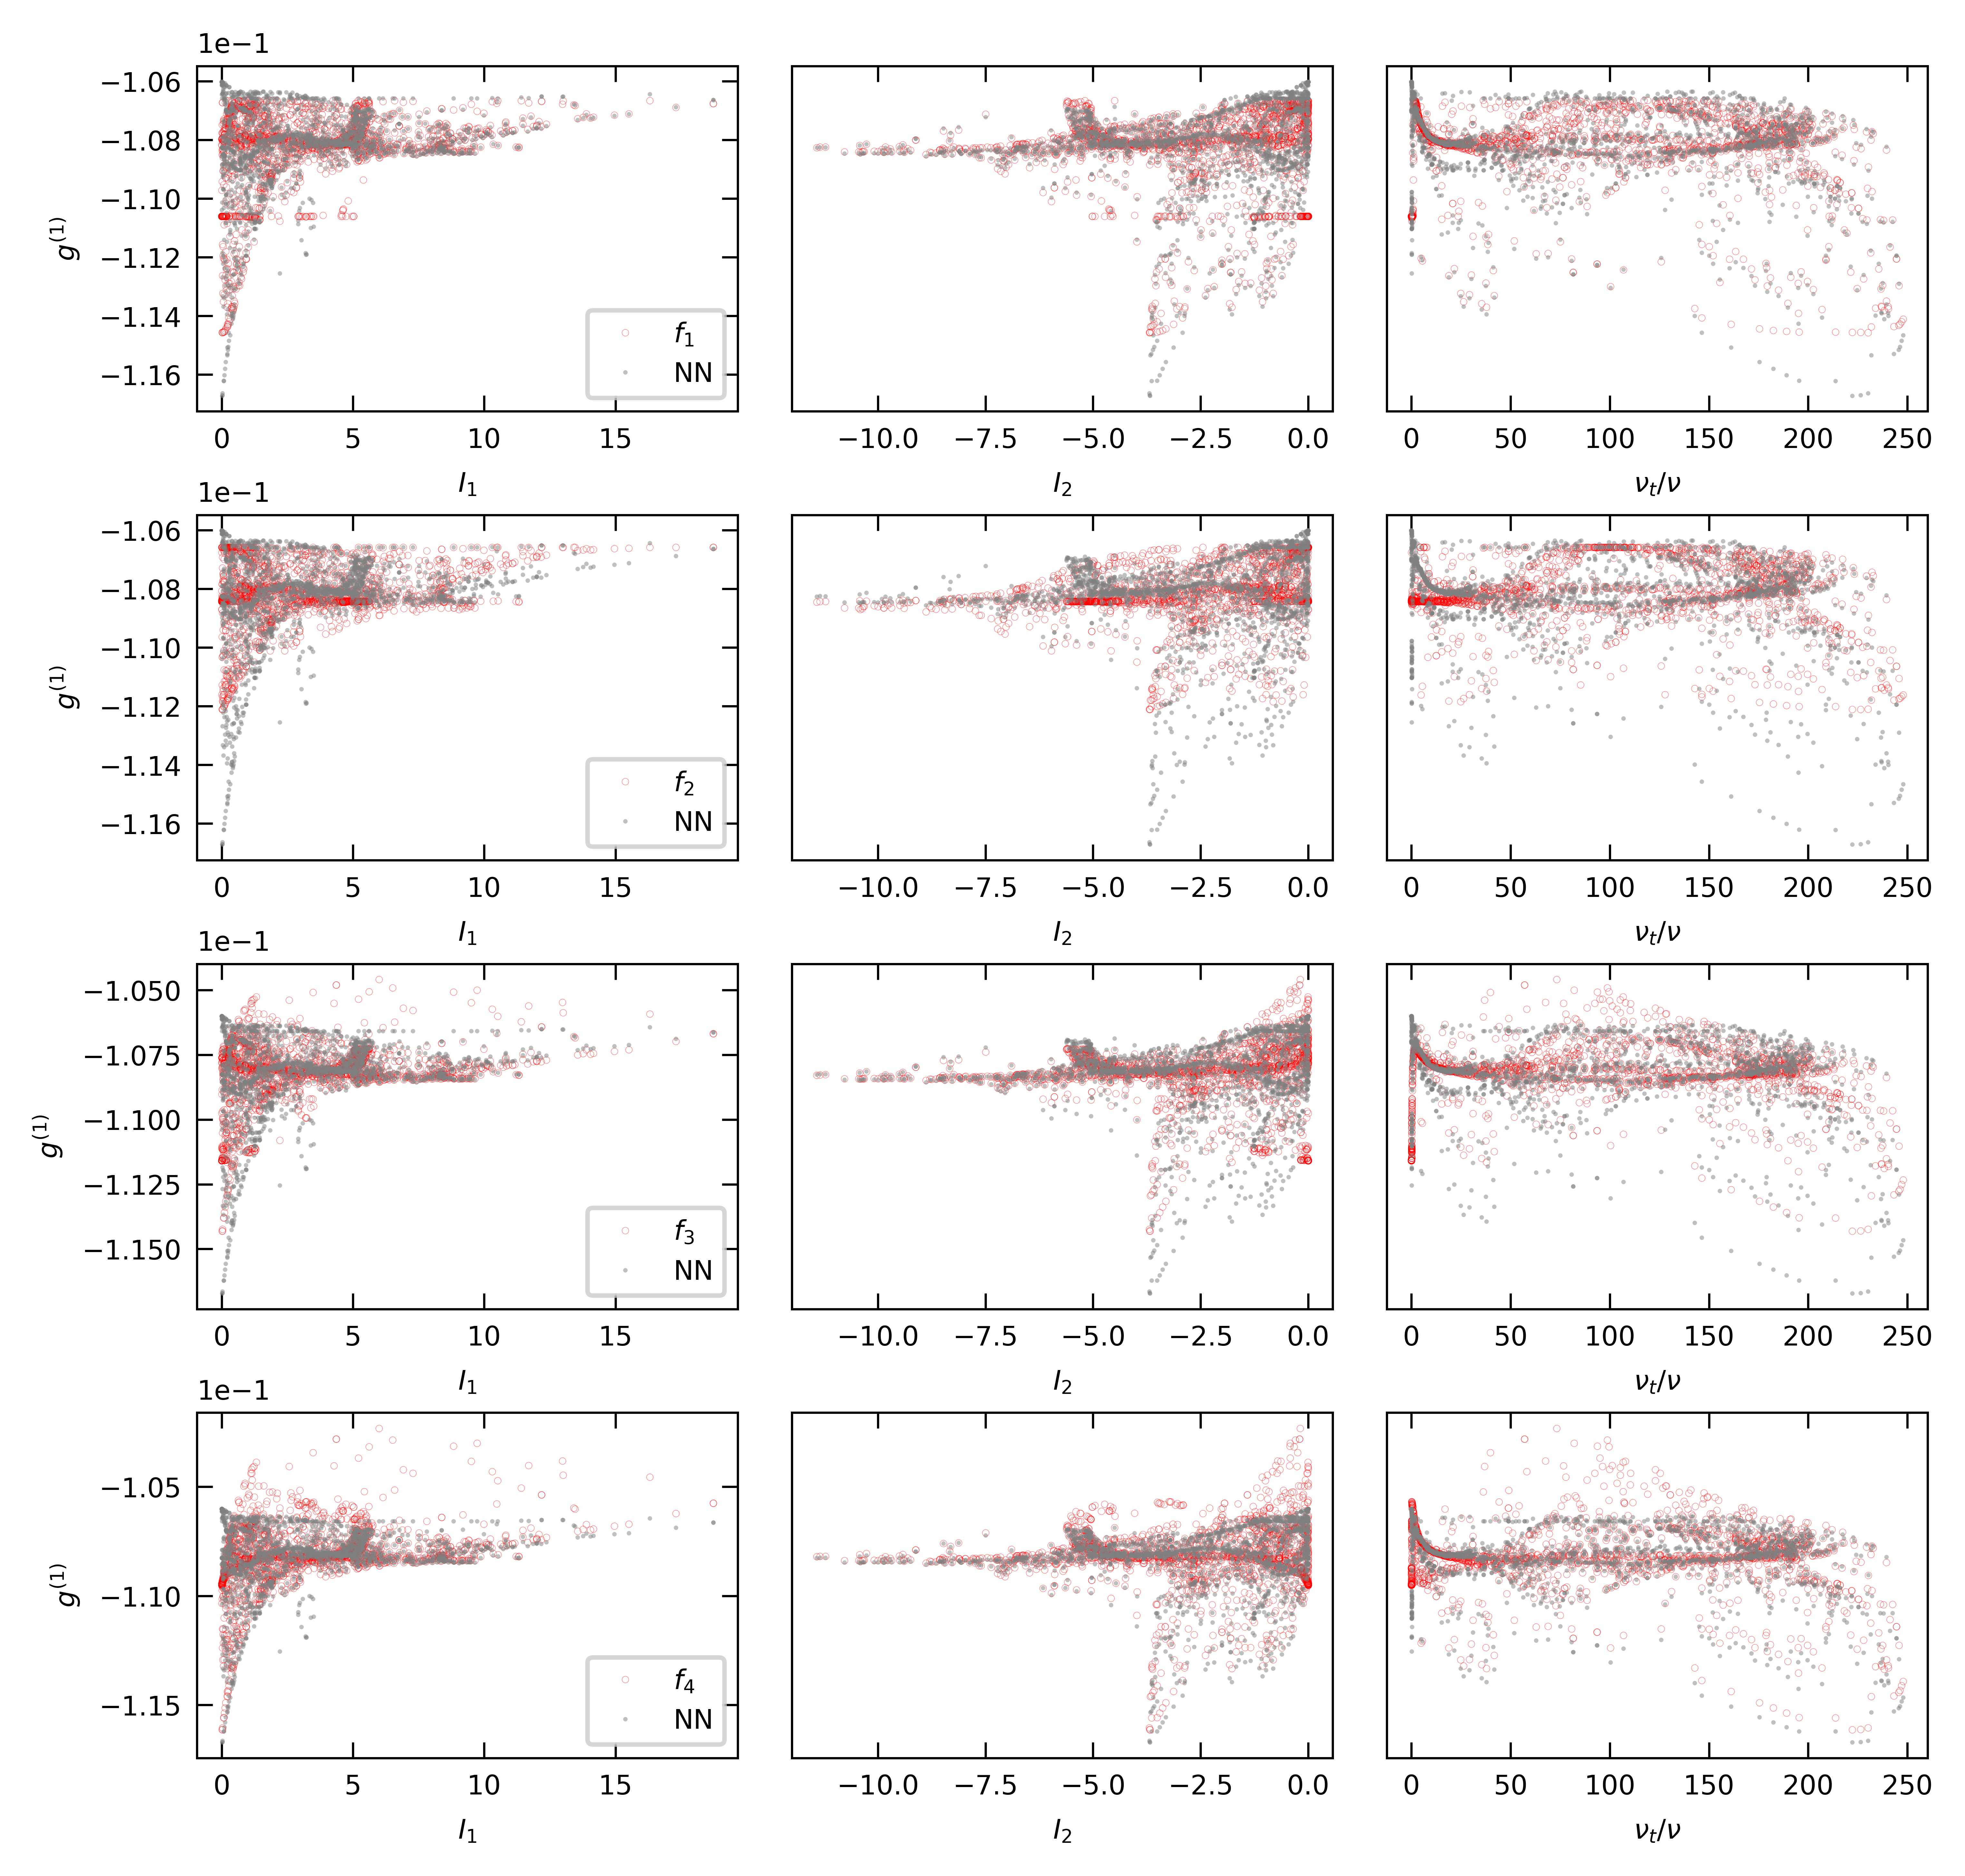

In [50]:
import numpy as np
import matplotlib.pyplot as plt

featuresName = [r'$I_1$', r'$I_2$', r'$\nu_t/\nu$']
gName = [r'$g^{(1)}$', r'$g^{(2)}$']
sampleId = np.random.randint(0, np.size(features[:, 0]), 2000)

fig, ax = plt.subplots(4, 3, figsize=(6, 6))

for j in range(3):
    ax[0][j].plot(features[sampleId, j],
                  g1_sr_scaled_1(features_scaled[sampleId, 0],
                                 features_scaled[sampleId, 1],
                                 features_scaled[sampleId, 2]),
                  '.',
                  markersize=3,
                  markerfacecolor='none',
                  markeredgecolor='red',
                  markeredgewidth=0.1,
                  alpha=0.5,
                  label='$f_1$')
    error = np.mean(
        np.abs(
            g1_sr_scaled_1(features_scaled[sampleId, 0], features_scaled[
                sampleId, 1], features_scaled[sampleId, 2]) - g[sampleId, 0]))
    print('f1 error', error)

    ax[1][j].plot(features[sampleId, j],
                  g1_sr_1(features[sampleId, 0], features[sampleId, 1],
                          features[sampleId, 2]),
                  '.',
                  markersize=3,
                  markerfacecolor='none',
                  markeredgecolor='red',
                  markeredgewidth=0.1,
                  alpha=0.5,
                  label='$f_2$')

    error = np.mean(
        np.abs(
            g1_sr_1(features[sampleId, 0], features[sampleId,
                                                    1], features[sampleId,
                                                                 2]) -
            g[sampleId, 0]))
    print('f2 error', error)

    ax[2][j].plot(features[sampleId, j],
                  g1_sr_3(features_scaled[sampleId,
                                          0], features_scaled[sampleId, 1],
                          features_scaled[sampleId, 2]),
                  '.',
                  markersize=3,
                  markerfacecolor='none',
                  markeredgecolor='red',
                  markeredgewidth=0.1,
                  alpha=0.5,
                  label='$f_3$')
    error = np.mean(
        np.abs(
            g1_sr_3(features_scaled[sampleId, 0], features_scaled[sampleId, 1],
                    features_scaled[sampleId, 2]) - g[sampleId, 0]))
    print('f3 error', error)

    ax[3][j].plot(features[sampleId, j],
                  g1_sr_4(features_scaled[sampleId,
                                          0], features_scaled[sampleId, 1],
                          features_scaled[sampleId, 2]),
                  '.',
                  markersize=3,
                  markerfacecolor='none',
                  markeredgecolor='red',
                  markeredgewidth=0.1,
                  alpha=0.5,
                  label='$f_4$')
    error = np.mean(
        np.abs(
            g1_sr_4(features_scaled[sampleId, 0], features_scaled[sampleId, 1],
                    features_scaled[sampleId, 2]) - g[sampleId, 0]))
    print('f4 error', error)
    # ax[0][j].set(ylim=(-0.12, -0.1))
    for i in range(4):
        ax[i][j].plot(features[sampleId, j],
                      g[sampleId, 0],
                      '.',
                      markersize=2,
                      markeredgecolor='none',
                      alpha=0.5,
                      color='gray',
                      label='NN')
        ax[i][j].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax[i][j].set(xlabel=featuresName[j])
        if j == 0: ax[i][j].set(ylabel=gName[0])
        else: ax[i][j].set(yticks=([]))
        ax[i][0].legend()

plt.subplots_adjust(left=0.08,
                    right=0.975,
                    bottom=0.075,
                    top=0.95,
                    wspace=0.1,
                    hspace=0.3)
plt.savefig('SR-check.png')
